<a href="https://colab.research.google.com/github/asadiv/Pytorch/blob/main/02_pytorch_classification_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

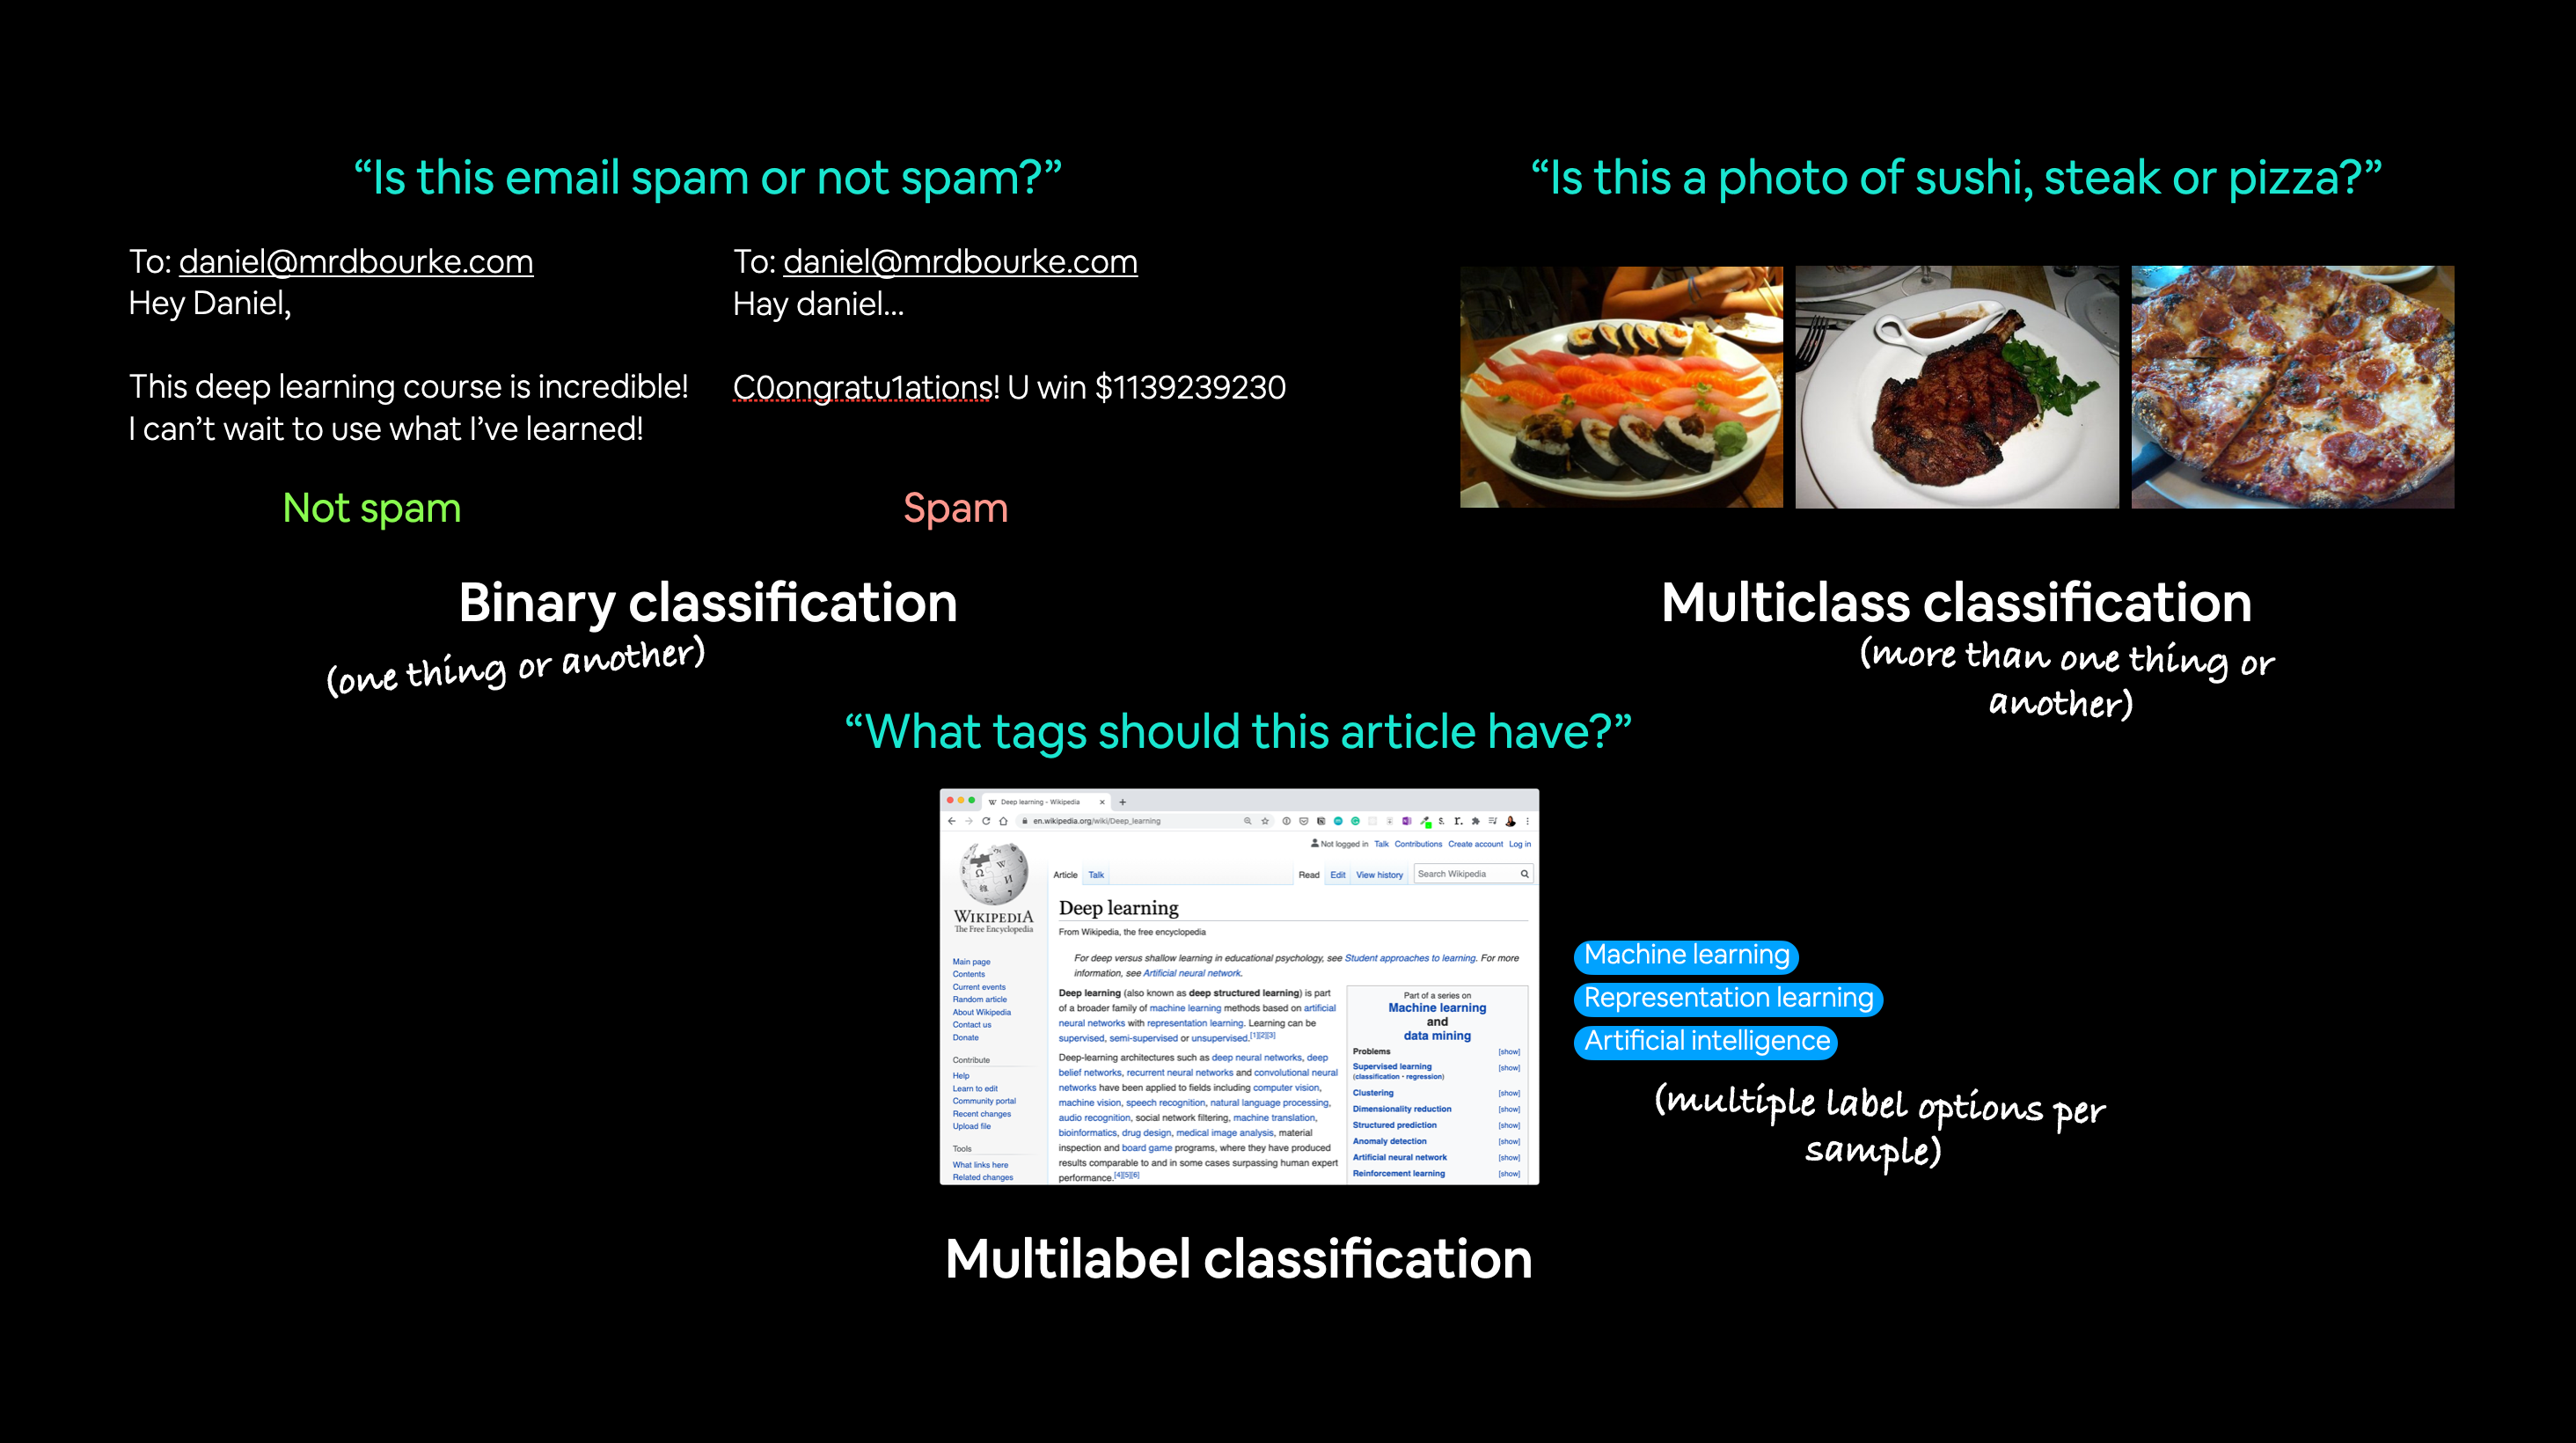

In [32]:
# getting some classification data using scikitlearn
from sklearn.datasets import make_circles
n_samples = 1000
x, y = make_circles(n_samples, noise=0.03, random_state=42)
print(x[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [33]:
#make dataframe of data
import pandas as pd
df = pd.DataFrame(x, columns=['x1', 'x2'])
df['label'] = y
df.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [34]:
# binary classification prblem with 500 values for each 1 and 0
df.label.value_counts()

,count
label,
1,500
0,500


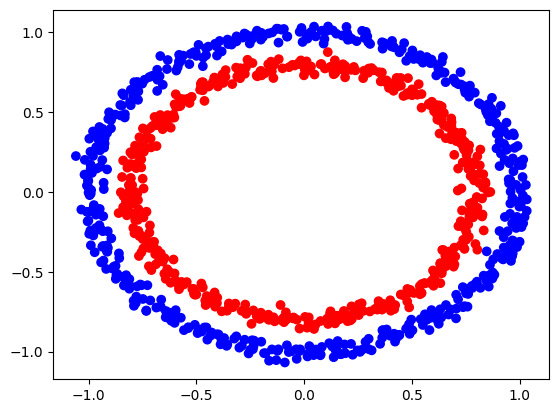

In [35]:
# visulaize
import matplotlib.pyplot as plt
plt.scatter(df.x1, df.x2, c=df.label, cmap='bwr')
plt.show()

In [36]:
#check the shapes of features and labels
# x has two features corresponding to 1 y label
x.shape,y.shape

((1000, 2), (1000,))

In [37]:
type(x), type(y) # types are numpy array now

(numpy.ndarray, numpy.ndarray)

In [38]:
# convert data into tensors and create train test splits
import torch
from sklearn.model_selection import train_test_split
X = torch.from_numpy(x).type(torch.float)
Y = torch.from_numpy(y).type(torch.float)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)# (randomstate)make the random split reproducible
len(x_train), len(x_test)

(800, 200)

In [39]:
# build a model
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [40]:
from torch import nn
class binaryClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2,out_features=5) # input size 2 and output 5
    self.layer2 = nn.Linear(in_features=5,out_features=1) #input size 5 and output 1
  def forward(self,x):
    return self.layer2(self.layer1(x)) #goes through layer1 and then layer2

model0 = binaryClassificationModel()
model0.to(device)

binaryClassificationModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [41]:
#we could use nn.sequential
#nn.Sequential performs a forward pass computation of the input data through the layers in the order they appear
model0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)
model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [42]:
#make predictions with untrained model
with torch.inference_mode():
  untrained_preds = model0(x_test.to(device))
print(f"shape of preds: {untrained_preds.shape}")
print(f"shape of labels: {y_test.shape}")
print(f"first 10 preds: {untrained_preds[:10]}")
print(f"first 10 labels: {y_test[:10]}")


shape of preds: torch.Size([200, 1])
shape of labels: torch.Size([200])
first 10 preds: tensor([[-0.1923],
        [-0.1455],
        [-0.3913],
        [-0.1356],
        [-0.5125],
        [-0.4830],
        [-0.2552],
        [-0.3345],
        [-0.3859],
        [-0.1437]])
first 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


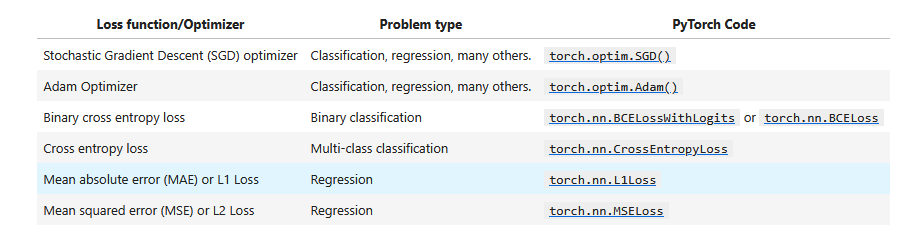

In [43]:
#loss function and optimizeer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model0.parameters(), lr=0.1)


In [44]:
#calculate accuracy fn
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [45]:
#logits are raw output of model
# we use sigmoid fun in binary classification to convert logits to probabilities
# In full
y_pred_labels = torch.round(torch.sigmoid(model0(x_test.to(device))[:5])) #just 5 outputs being rounded to 1or0 after converting to probs

# Get rid of extra dimension
y_pred_labels.squeeze()

tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [46]:
# build the training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
#move data to same device availabe
x_train,y_train = x_train.to(device),y_train.to(device)
x_test,y_test = x_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model0.train()
  y_logits = model0(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #logits-> labels
  loss = loss_fn(y_logits,y_train) # using logits cuz we are usng bcelogitsloss which has built in sigmoid and works on raw logits
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #testing
  model0.eval()
  with torch.inference_mode():
    test_logits = model0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch%10==0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70948 | Acc: 50.00% | Test Loss: 0.71181 | Test Acc: 50.00%
Epoch: 10 | Loss: 0.69993 | Acc: 50.00% | Test Loss: 0.70344 | Test Acc: 48.50%
Epoch: 20 | Loss: 0.69619 | Acc: 46.38% | Test Loss: 0.70008 | Test Acc: 44.50%
Epoch: 30 | Loss: 0.69468 | Acc: 48.50% | Test Loss: 0.69859 | Test Acc: 46.00%
Epoch: 40 | Loss: 0.69403 | Acc: 49.12% | Test Loss: 0.69780 | Test Acc: 47.00%
Epoch: 50 | Loss: 0.69371 | Acc: 50.00% | Test Loss: 0.69729 | Test Acc: 46.50%
Epoch: 60 | Loss: 0.69353 | Acc: 49.75% | Test Loss: 0.69690 | Test Acc: 46.00%
Epoch: 70 | Loss: 0.69341 | Acc: 50.50% | Test Loss: 0.69659 | Test Acc: 46.50%
Epoch: 80 | Loss: 0.69333 | Acc: 50.62% | Test Loss: 0.69632 | Test Acc: 47.00%
Epoch: 90 | Loss: 0.69326 | Acc: 50.62% | Test Loss: 0.69610 | Test Acc: 47.00%


In [47]:
# the loss is too much and now lets see whats happening
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


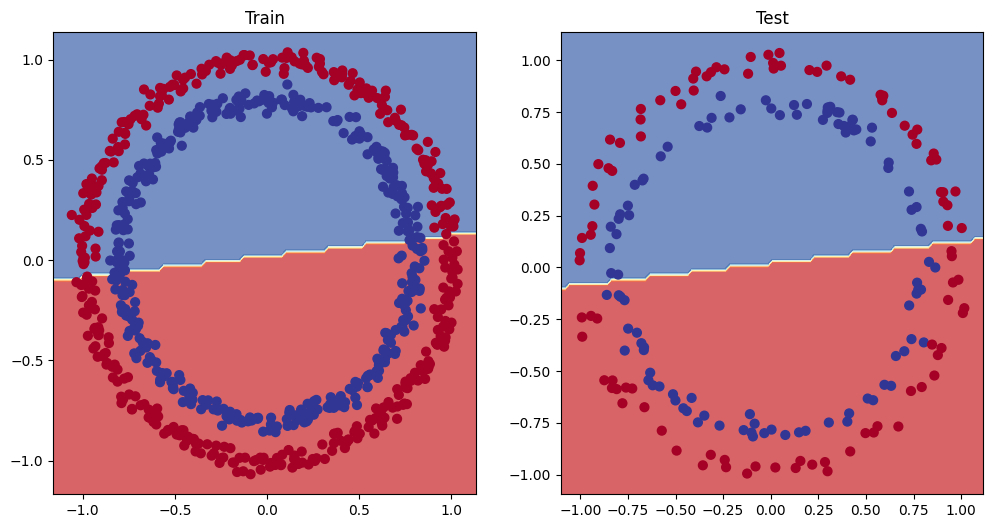

In [48]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, x_test, y_test)

model is trying to split the dots using a straight line we need non linearity here- lets imporve this

In [49]:
#lets introduce nonlinearity to our model
from torch import nn
class binaryClassificationModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model1 = binaryClassificationModel2().to(device)
print(model1)

binaryClassificationModel2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [57]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)

In [58]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = x_train.to(device), y_train.to(device)
X_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57434, Test Accuracy: 86.50%
Epoch: 100 | Loss: 0.56076, Accuracy: 88.50% | Test Loss: 0.56802, Test Accuracy: 88.00%
Epoch: 200 | Loss: 0.55313, Accuracy: 89.25% | Test Loss: 0.56144, Test Accuracy: 89.00%
Epoch: 300 | Loss: 0.54518, Accuracy: 90.00% | Test Loss: 0.55461, Test Accuracy: 89.50%
Epoch: 400 | Loss: 0.53695, Accuracy: 90.75% | Test Loss: 0.54752, Test Accuracy: 89.50%
Epoch: 500 | Loss: 0.52845, Accuracy: 91.38% | Test Loss: 0.54013, Test Accuracy: 89.50%
Epoch: 600 | Loss: 0.51967, Accuracy: 92.38% | Test Loss: 0.53258, Test Accuracy: 89.50%
Epoch: 700 | Loss: 0.51053, Accuracy: 92.75% | Test Loss: 0.52476, Test Accuracy: 90.00%
Epoch: 800 | Loss: 0.50106, Accuracy: 93.12% | Test Loss: 0.51655, Test Accuracy: 90.00%
Epoch: 900 | Loss: 0.49138, Accuracy: 93.50% | Test Loss: 0.50832, Test Accuracy: 89.50%


In [59]:
# Make predictions
model1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model1(X_test))).squeeze()

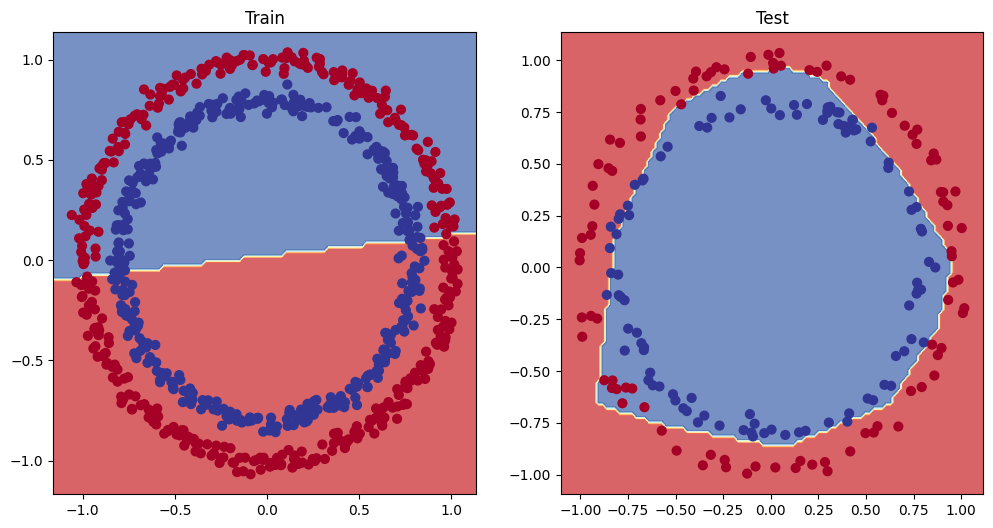

In [60]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train) # model0 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test) # model1 = has non-linearity

**Multi-class classification**

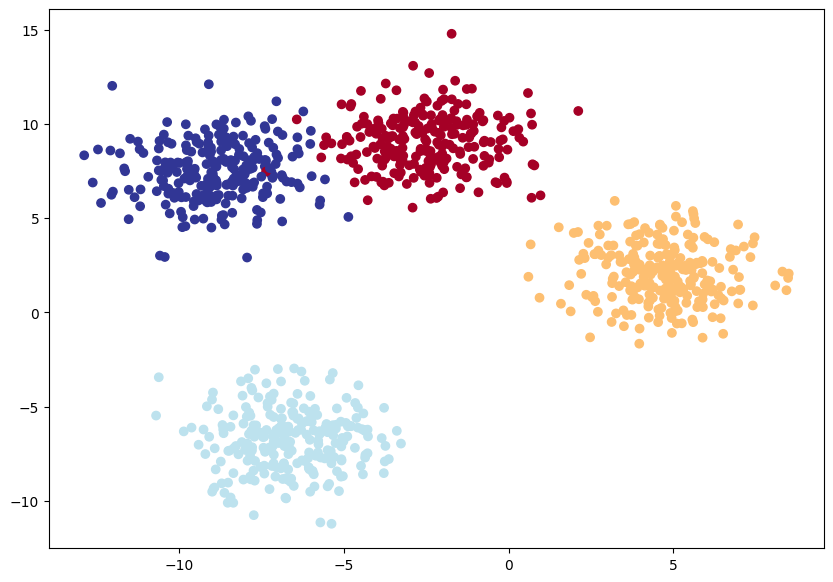

In [63]:
import torch
from torch import nn
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Classes = 4
Features = 2
random_seed = 42

#create multi class data
X_blob,Y_blob = make_blobs(n_samples=1000,
                           n_features=Features, # features per x
                           centers = Classes, #ylabels
                           cluster_std=1.5, #gives the cliuster a little shake
                           random_state=random_seed
                           )
# turn into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.LongTensor)

#split data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    Y_blob,
    test_size=0.2,
    random_state=random_seed
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, cmap=plt.cm.RdYlBu);

In [64]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [65]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=Features,
                    output_features=Classes,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [67]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

In [68]:
# Perform a single forward pass on the data
model_4(X_blob_train.to(device))[:5]


tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [70]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, Classes

(torch.Size([4]), 4)

In [71]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


In [72]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [73]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [76]:
y_blob_test.shape,y_pred_probs.shape,y_preds.shape

(torch.Size([200]), torch.Size([200, 4]), torch.Size([200]))

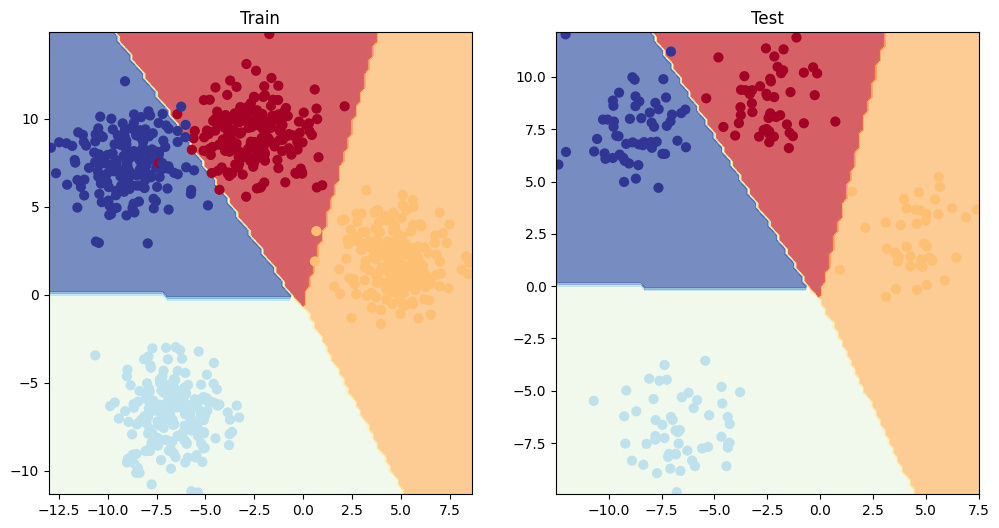

In [77]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)